In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from os.path import abspath
from os import chdir
from statsmodels.tsa.seasonal import STL

In [2]:
joined_df = pd.read_csv('joined_df.csv', header=0)

In [3]:
joined_df = joined_df.set_index('Date Local')

In [4]:
chdir(abspath('../'))

In [5]:
abspath('')

'/mnt/c/Users/Rajkumar/OneDrive - The George Washington University/Time Series Analysis'

In [6]:
from Utilities.GPAC import gpac_table
from Utilities.WhitenessTest import WhitenessTest as WT

In [7]:
def whiteness_test(x, name):
    wt = WT(x)
    print(f"ADF test for {name}:\n")
    wt.ADF_Cal()
    wt.Plot_Rolling_Mean_Var(name="name")

In [8]:
def seasonal_differencing(y, seasonal_period):
    m = seasonal_period
    s_diff = []
    for t in range(m, len(y)):
        s_diff.append(y[t] - y[t-m])
    return s_diff

In [9]:
def print_strength_seas_tren(x, name):
    stl = STL(x, period=12).fit()
    residual = stl.resid
    trend = stl.trend
    seasonal = stl.seasonal
    f_t = np.max([0, 1-(np.var(residual)/np.var(residual + trend))]) # denominator = seasonally adjusted data
    f_s = np.max([0, 1-(np.var(residual)/np.var(residual + seasonal))]) # denominator = detrended data
    print(f"Strength of trend in {name} is: {f_t * 100}%")
    print(f"Strength of seasonality in {name} is {f_s * 100}%")

In [10]:
def plot_acf_pacf(x, lags, xlims=None):
    r_idx = 0
    if xlims:
        fig, axes = plt.subplots(len(xlims), 2, sharex=False, sharey=True, figsize=(15, 10))
        for xlim in xlims:
            plot_acf(x, lags=lags, ax=axes[r_idx, 0])
            plot_pacf(x, lags=lags, ax=axes[r_idx, 1])
            axes[r_idx, 0].set_xlim(xlim)
            axes[r_idx, 1].set_xlim(xlim)
            r_idx += 1
    else:
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=(11, 5))
        plot_acf(x, lags=lags, ax=axes[0])
        plot_pacf(x, lags=lags, ax=axes[1])
    plt.tight_layout()
    plt.show()

### Original Data

In [11]:
joined_df.reset_index()['Date Local'].min()

'2000-01-01'

In [12]:
joined_df.reset_index()['Date Local'].max()

'2016-03-31'

In [13]:
N = joined_df.shape[0]
train_test_split = int(0.7 * N)
co = joined_df.reset_index()['CO AQI'][:train_test_split]
co_test = joined_df.reset_index()['CO AQI'][train_test_split:]

In [14]:
test_len = N - train_test_split

In [15]:
co_test_log = np.log(co_test)

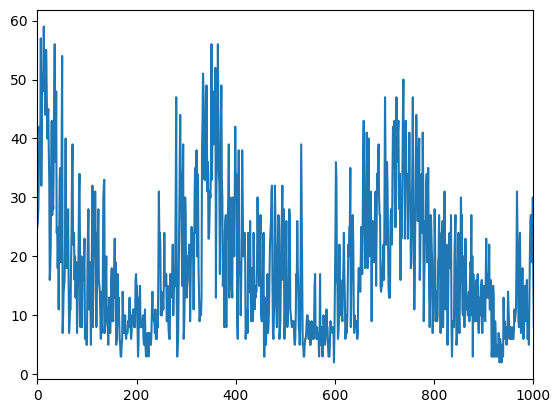

In [16]:
plt.figure()
co.plot()
plt.xlim([0, 1000])
plt.show()

In [17]:
print_strength_seas_tren(co, name='Raw data')

Strength of trend in Raw data is: 78.57788169398243%
Strength of seasonality in Raw data is 37.454057571565826%


ADF test for log transformed and differenced:

ADF Statistic: -5.734318
p-value: 0.000001
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


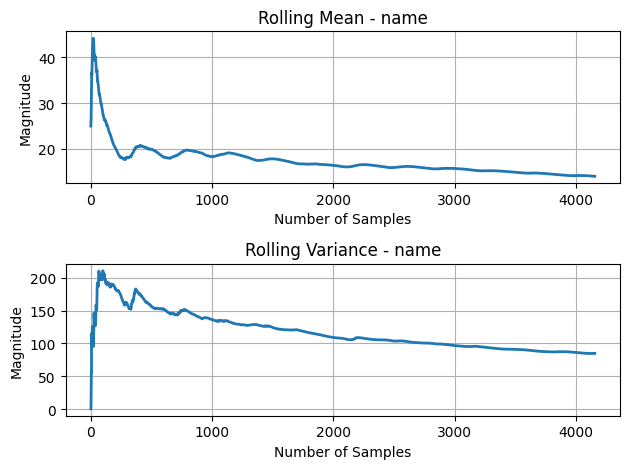

In [18]:
whiteness_test(co, name='log transformed and differenced')

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


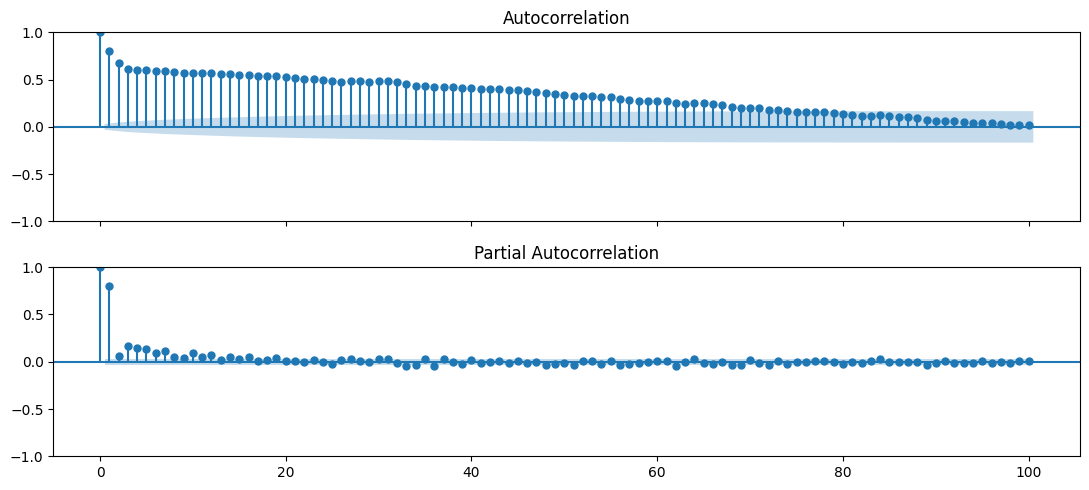

In [19]:
plot_acf_pacf(co, lags=100)

## Log transformation

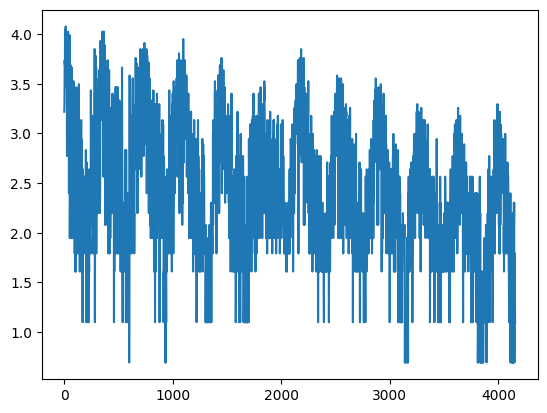

In [20]:
co_log = np.log(co)
plt.figure()
plt.plot(co_log)
plt.show()

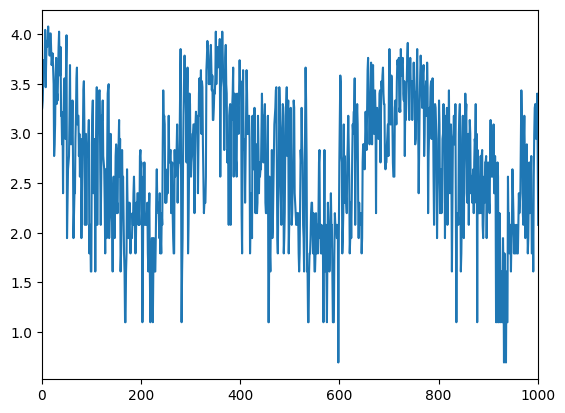

In [21]:
plt.figure()
plt.plot(co_log)
plt.xlim([0, 1000])
plt.show()

In [22]:
print_strength_seas_tren(co, name='Original data')
print('')
print_strength_seas_tren(co_log, name='Log transformed data')


Strength of trend in Original data is: 78.57788169398243%
Strength of seasonality in Original data is 37.454057571565826%

Strength of trend in Log transformed data is: 78.29234750495951%
Strength of seasonality in Log transformed data is 35.7691123968119%


ADF test for CO diff1:

ADF Statistic: -5.014841
p-value: 0.000021
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


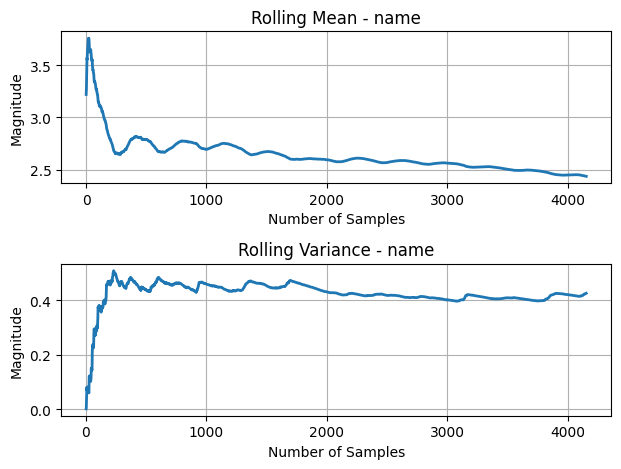

In [23]:
whiteness_test(pd.Series(co_log), 'CO AQI log transformed')

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


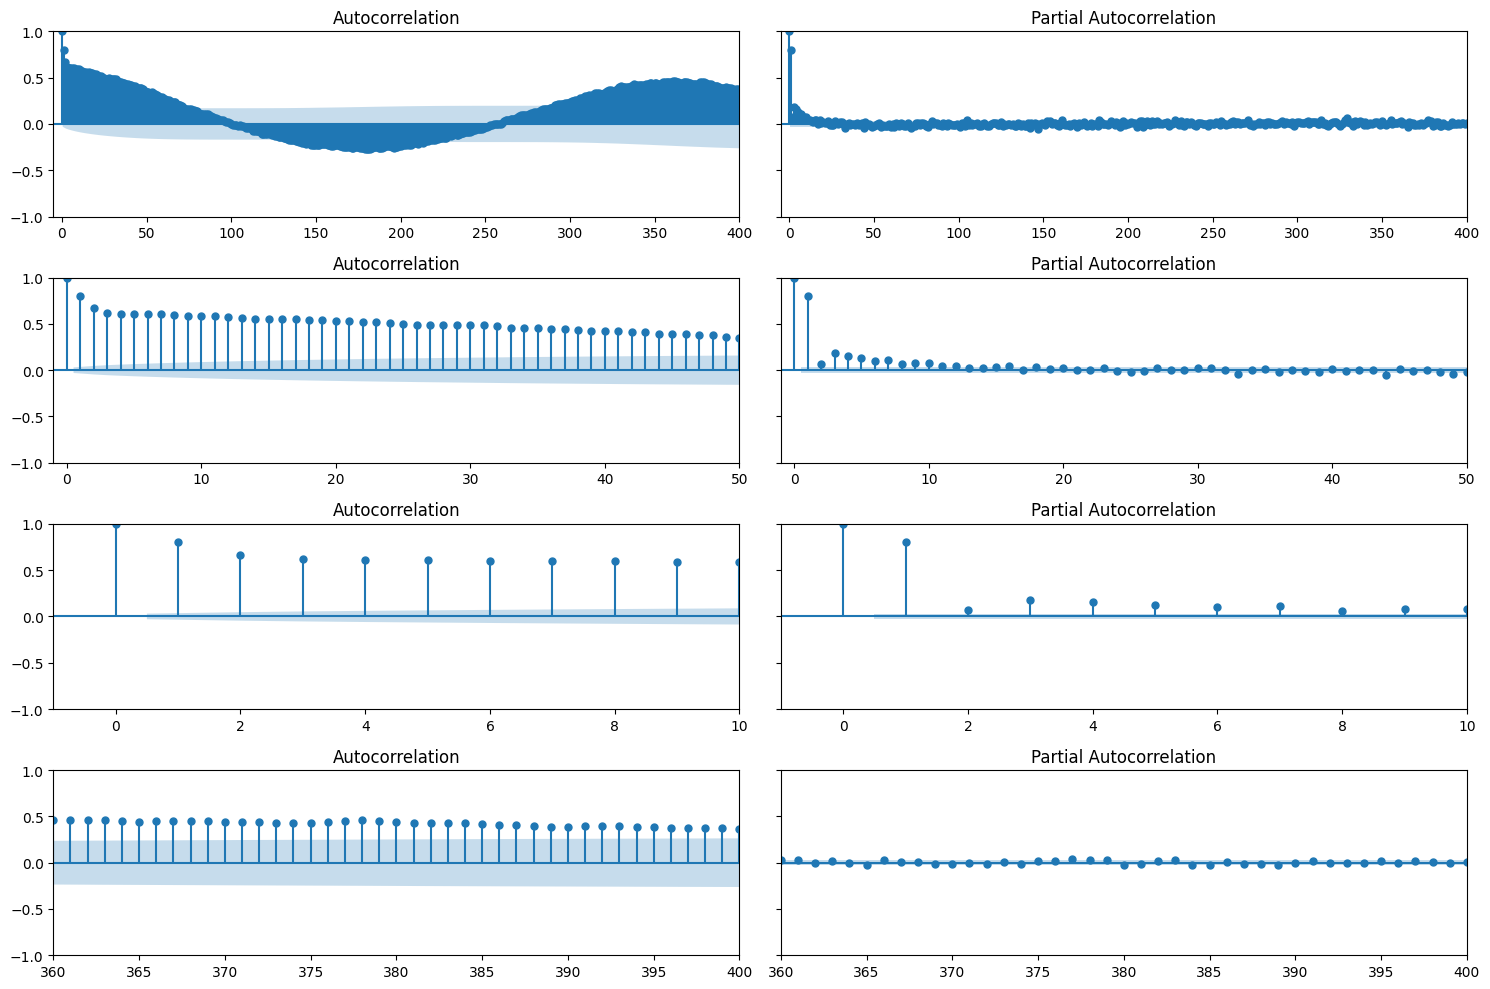

In [24]:
plot_acf_pacf(co_log, lags=400, xlims=[[-5, 400], [-1, 50], [-1, 10], [360, 400]])

### GPAC

In [25]:
from Utilities.Correlation import Correlation as Corr
corr = Corr()

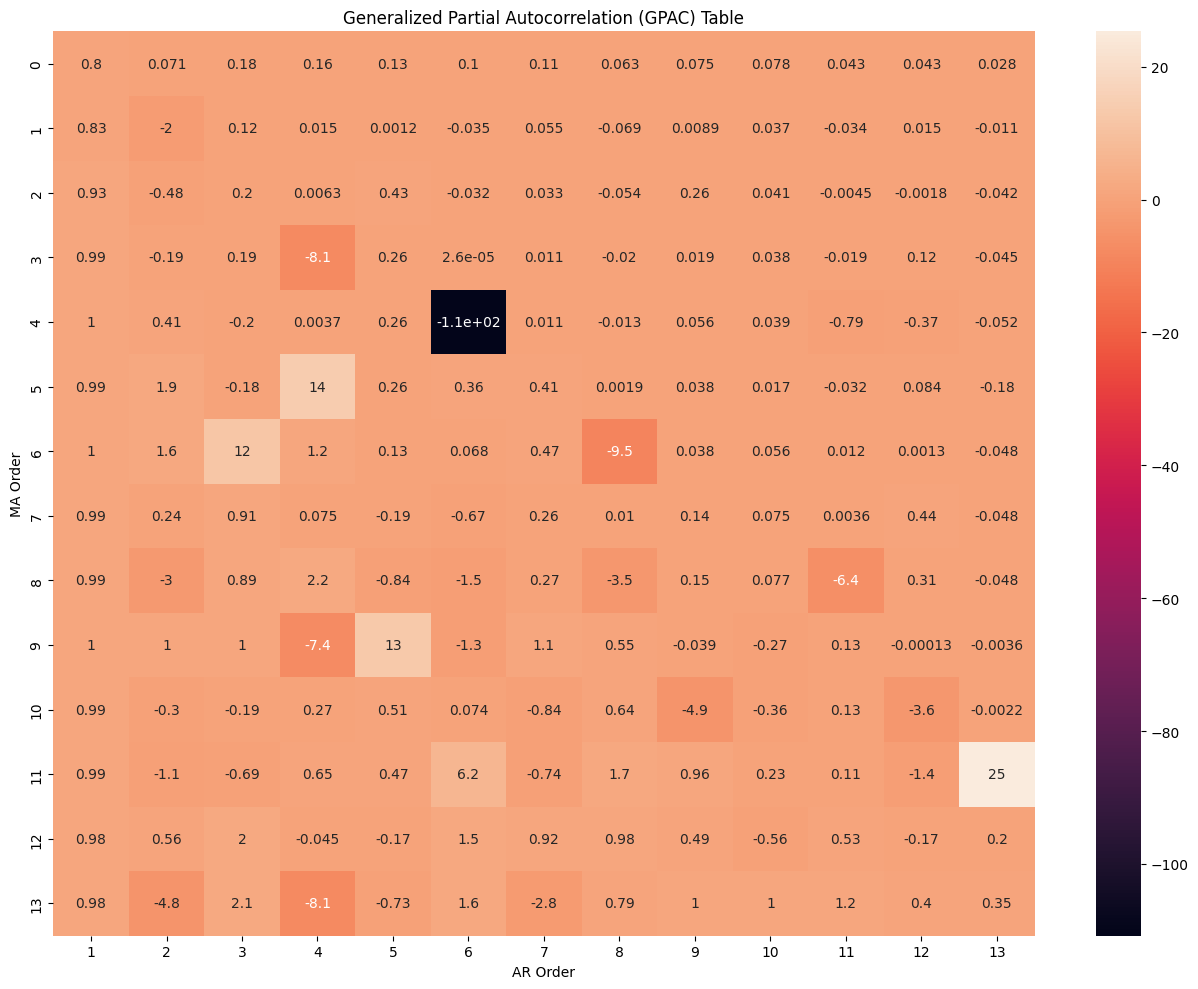

In [26]:
acf_vals, _ = corr.acf(co_log, max_lag=28, plot=False, return_acf=True)
gpac_vals = gpac_table(acf_vals, na=13, nb=13, plot=False)
plt.figure(figsize=(13, 10))
sns.heatmap(gpac_vals, annot=True)
plt.xticks(ticks=np.array(list(range(13))) + .5, labels=list(range(1, 14)))
plt.title('Generalized Partial Autocorrelation (GPAC) Table')
plt.xlabel('AR Order')
plt.ylabel('MA Order')
plt.tight_layout()
plt.show()

### Model for Log transformed CO

In [27]:
sarima1 = sm.tsa.statespace.SARIMAX(endog=co_log, order=(1,0,0),
                                   seasonal_order=(0,0,1,3), trend='n').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86882D-01    |proj g|=  3.60953D-01

At iterate    5    f=  5.24236D-01    |proj g|=  3.37538D-02

At iterate   10    f=  5.23642D-01    |proj g|=  3.08545D-03

At iterate   15    f=  5.23542D-01    |proj g|=  2.84180D-02

At iterate   20    f=  5.23473D-01    |proj g|=  2.58270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   1.882D-05   5.235D-01
  F =  0.52347283112050624     

CONVERG

 This problem is unconstrained.


In [28]:
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              CO AQI   No. Observations:                 4155
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 3)   Log Likelihood               -2175.030
Date:                             Wed, 21 Dec 2022   AIC                           4356.059
Time:                                     21:14:09   BIC                           4375.055
Sample:                                          0   HQIC                          4362.780
                                            - 4155                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9892      0.002    398.263      0.000       0.984       0.994
ma.S.L3       -0.0988      0.015     -6.718      0.000      -0.128      -0.070
sigma2         0.1667      0.003     55.876      0.000       0.161       0.173
===================================================================================
Ljung-Box (L1) (Q):                 149.86   Jarque-Bera (JB):               857.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
sarima1_yhat = sarima1.predict()

In [30]:
len(sarima1_yhat)

4155

In [31]:
len(co_log.iloc[1:])

4154

In [32]:
sarima1_residuals = co_log - sarima1_yhat

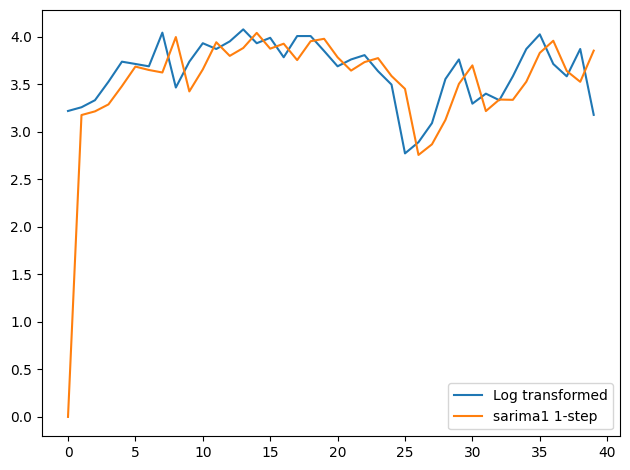

In [33]:
plt.figure()
plt.plot(co_log.iloc[:40], label='Log transformed')
plt.plot(sarima1_yhat.iloc[:40], label='sarima1 1-step')
plt.legend()
plt.tight_layout()
plt.show()

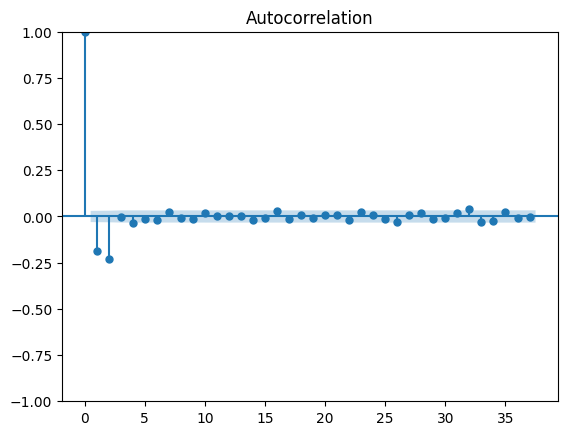

In [34]:
plot_acf(co_log - sarima1_yhat)
plt.show()

## 1st order differencing following Log transformation

In [35]:
co_diff1 = seasonal_differencing(co_log, seasonal_period=1)

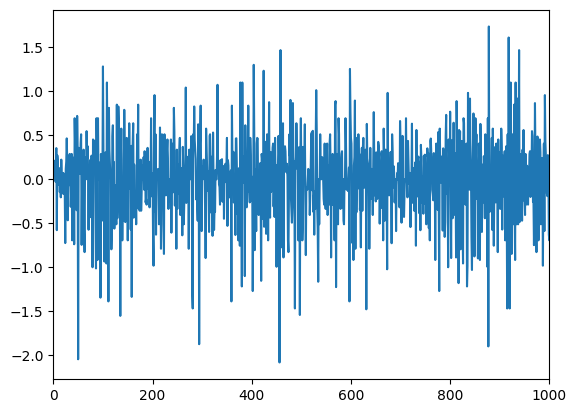

In [36]:
plt.plot(co_diff1)
plt.xlim([0, 1000])
plt.show()

ADF test for CO diff1:

ADF Statistic: -20.099069
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


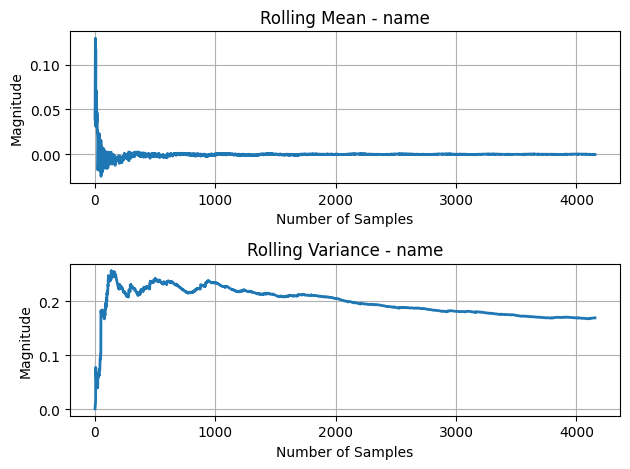

In [37]:
whiteness_test(pd.Series(co_diff1), 'CO diff1')

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


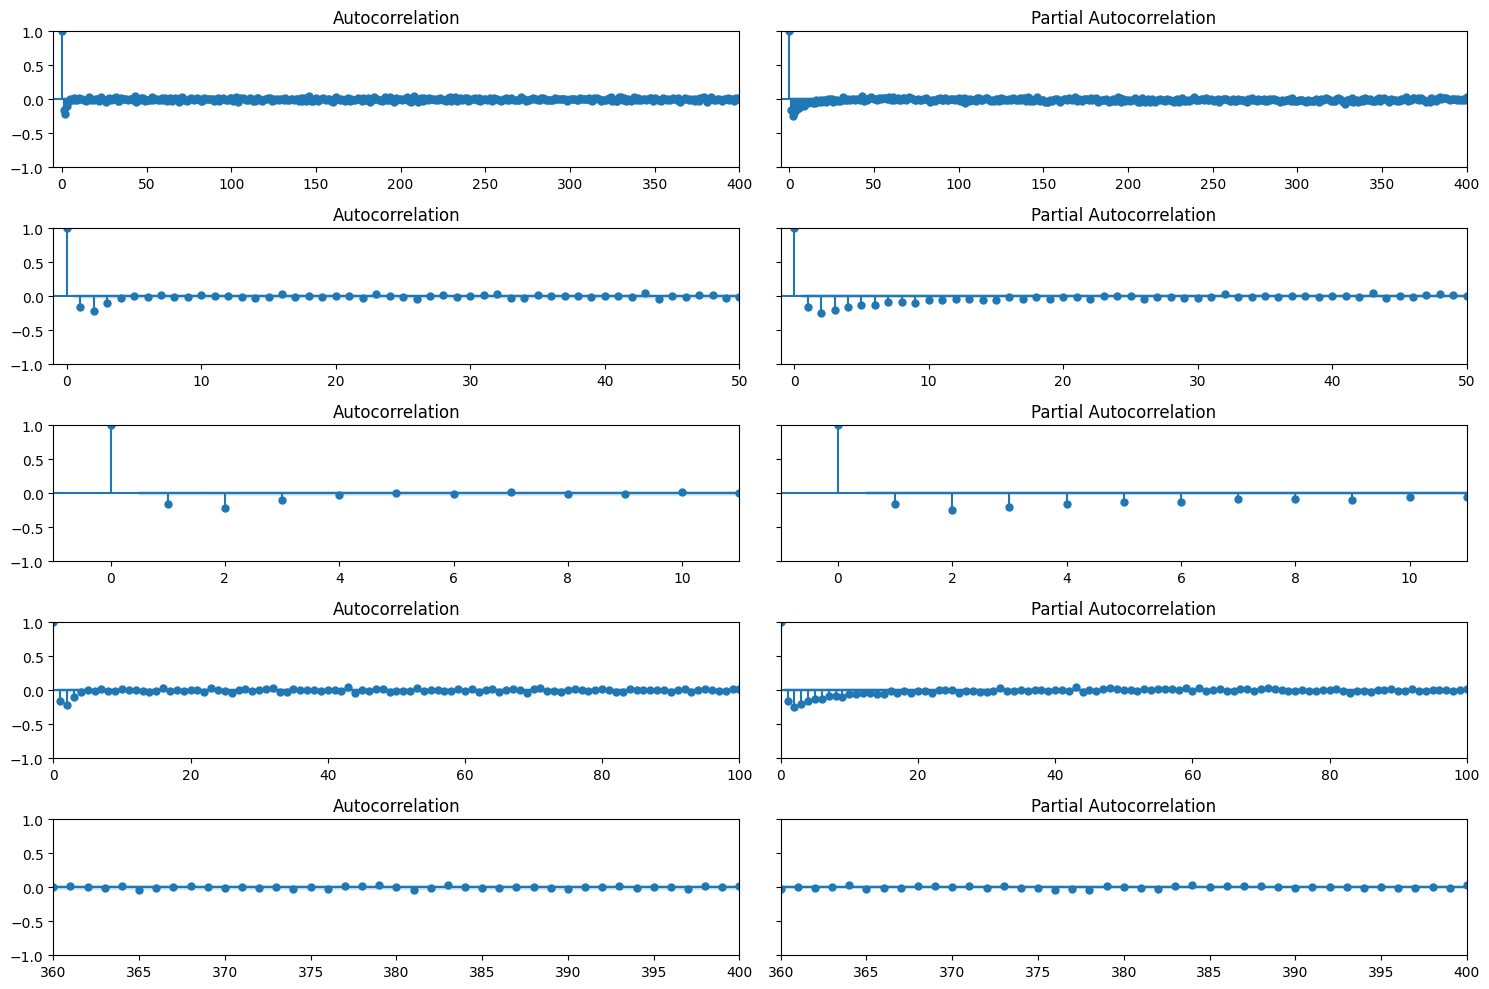

In [38]:
plot_acf_pacf(co_diff1, lags=400, xlims=[[-5, 400], [-1, 50], [-1, 11], [0, 100], [360, 400]])

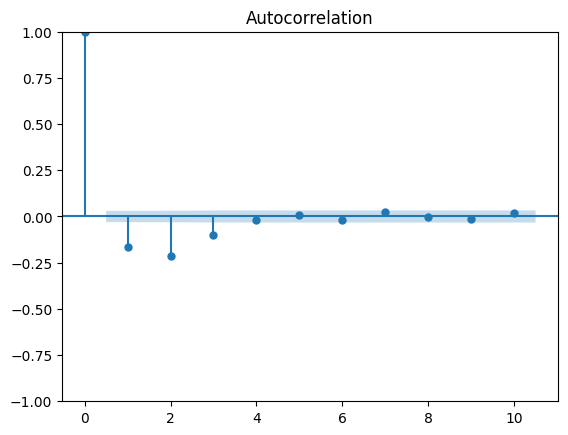

In [39]:
plot_acf(co_diff1, lags=10)
plt.show()

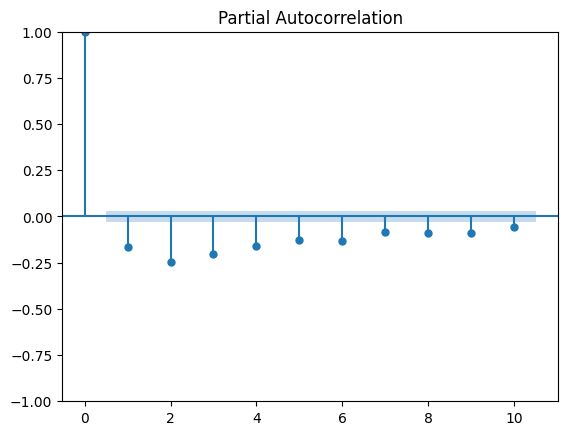

In [40]:
plot_pacf(co_diff1, lags=10)
plt.show()

Appears to be PACF exhibiting tail-off while ACF is showing cut-off pattern

## Second Order differencing

In [41]:
co_diff2 = seasonal_differencing(co_diff1, seasonal_period=1)

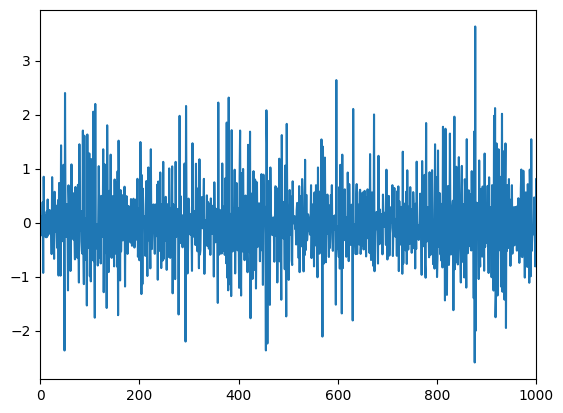

In [42]:
plt.figure()
plt.plot(co_diff2)
plt.xlim([0, 1000])
plt.show()

ADF test for CO diff2:

ADF Statistic: -23.903820
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


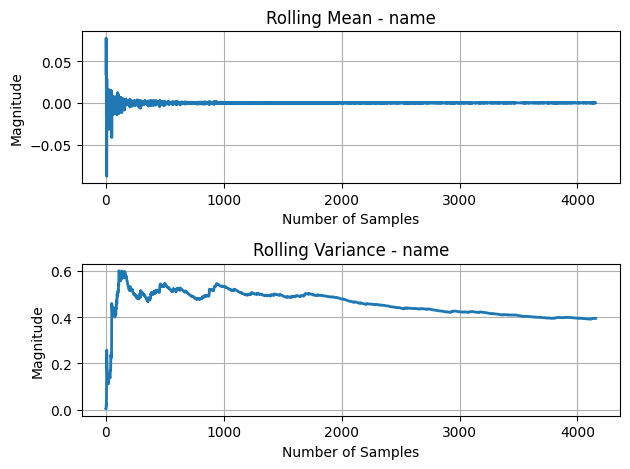

In [43]:
whiteness_test(pd.Series(co_diff2), 'CO diff2')

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


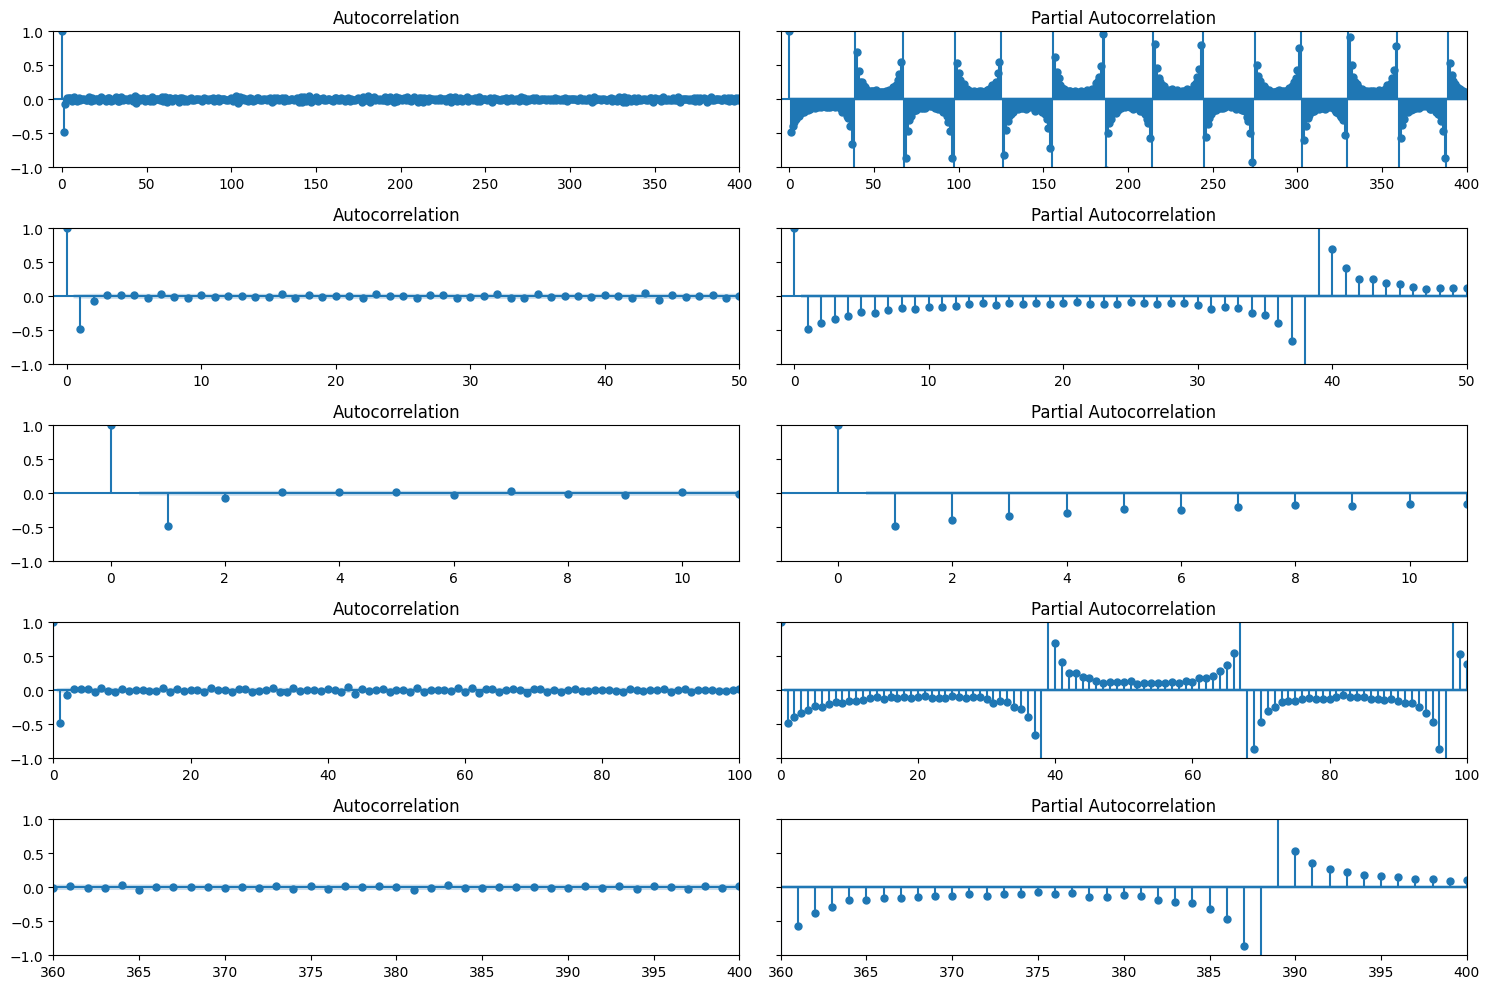

In [44]:
plot_acf_pacf(co_diff2, lags=400, xlims=[[-5, 400], [-1, 50], [-1, 11], [0, 100], [360, 400]])

In [45]:
print_strength_seas_tren(co_diff2, name='Second order non-seaonally differenced')

Strength of trend in Second order non-seaonally differenced is: 0.0%
Strength of seasonality in Second order non-seaonally differenced is 34.43389877273167%


### GPAC

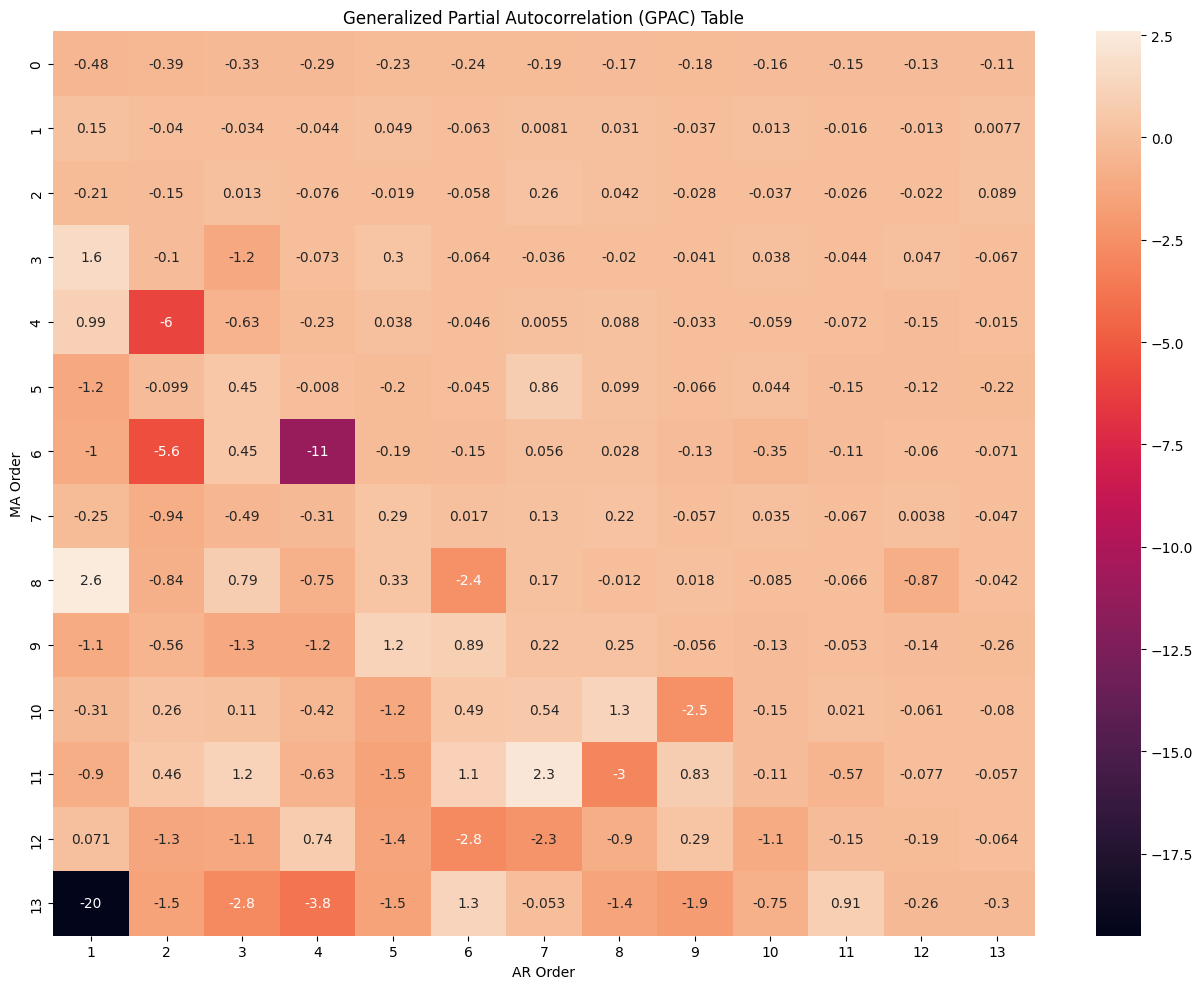

In [46]:
acf_vals, _ = corr.acf(co_diff2, max_lag=28, plot=False, return_acf=True)
gpac_vals = gpac_table(acf_vals, na=13, nb=13, plot=False)
plt.figure(figsize=(13, 10))
sns.heatmap(gpac_vals, annot=True)
plt.xticks(ticks=np.array(list(range(13))) + .5, labels=list(range(1, 14)))
plt.title('Generalized Partial Autocorrelation (GPAC) Table')
plt.xlabel('AR Order')
plt.ylabel('MA Order')
plt.tight_layout()
plt.show()

In [47]:
sarima2 = sm.tsa.statespace.SARIMAX(endog=co_log, 
                                    order=(0,0,1),
                                    seasonal_order=(0,2,0,3),
                                    trend='n').fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30196D+00    |proj g|=  1.15866D-01

At iterate    5    f=  1.29643D+00    |proj g|=  4.17577D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   4.176D-07   1.296D+00
  F =   1.2964292780674176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [48]:
sarima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             CO AQI   No. Observations:                 4155
Model:             SARIMAX(0, 0, 1)x(0, 2, [], 3)   Log Likelihood               -5386.664
Date:                            Wed, 21 Dec 2022   AIC                          10777.327
Time:                                    21:14:20   BIC                          10789.989
Sample:                                         0   HQIC                         10781.807
                                           - 4155                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3888      0.013     29.400      0.000       0.363       0.415
sigma2         0.7856      0.015     52.943      0.000       0.757       0.815
===================================================================================
Ljung-Box (L1) (Q):                  37.40   Jarque-Bera (JB):               142.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
sarima2_yhat = sarima2.predict()

In [50]:
sarima2_residuals = co_log - sarima2_yhat

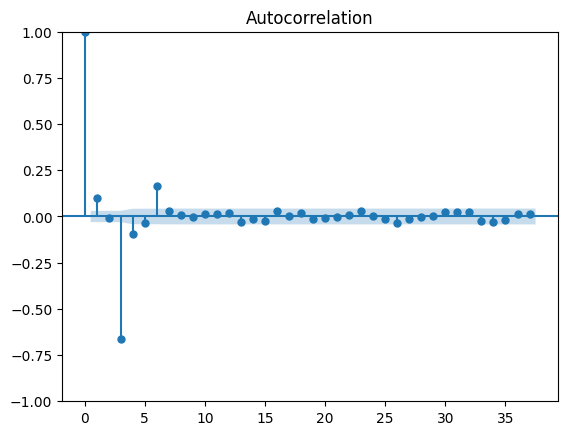

In [51]:
plot_acf(sarima2_residuals)
plt.show()

## Third order differencing

In [52]:
co_diff3 = seasonal_differencing(co_diff2, seasonal_period=1)

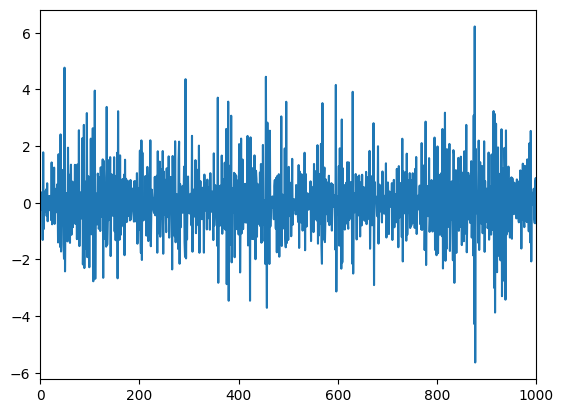

In [53]:
plt.figure()
plt.plot(co_diff3)
plt.xlim([0, 1000])
plt.show()

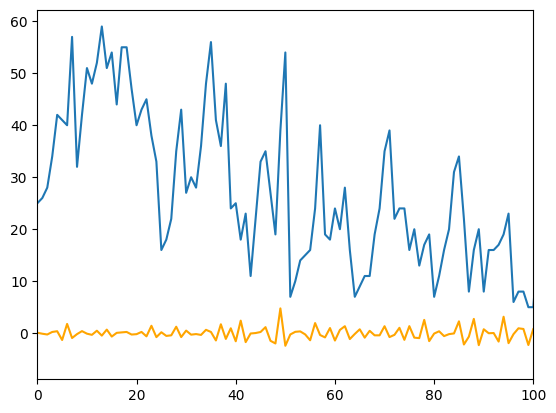

In [54]:
plt.figure()
plt.plot(co)
plt.plot(co_diff3, color='orange', label='second-order diff')
plt.xlim([0, 100])
plt.show()

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


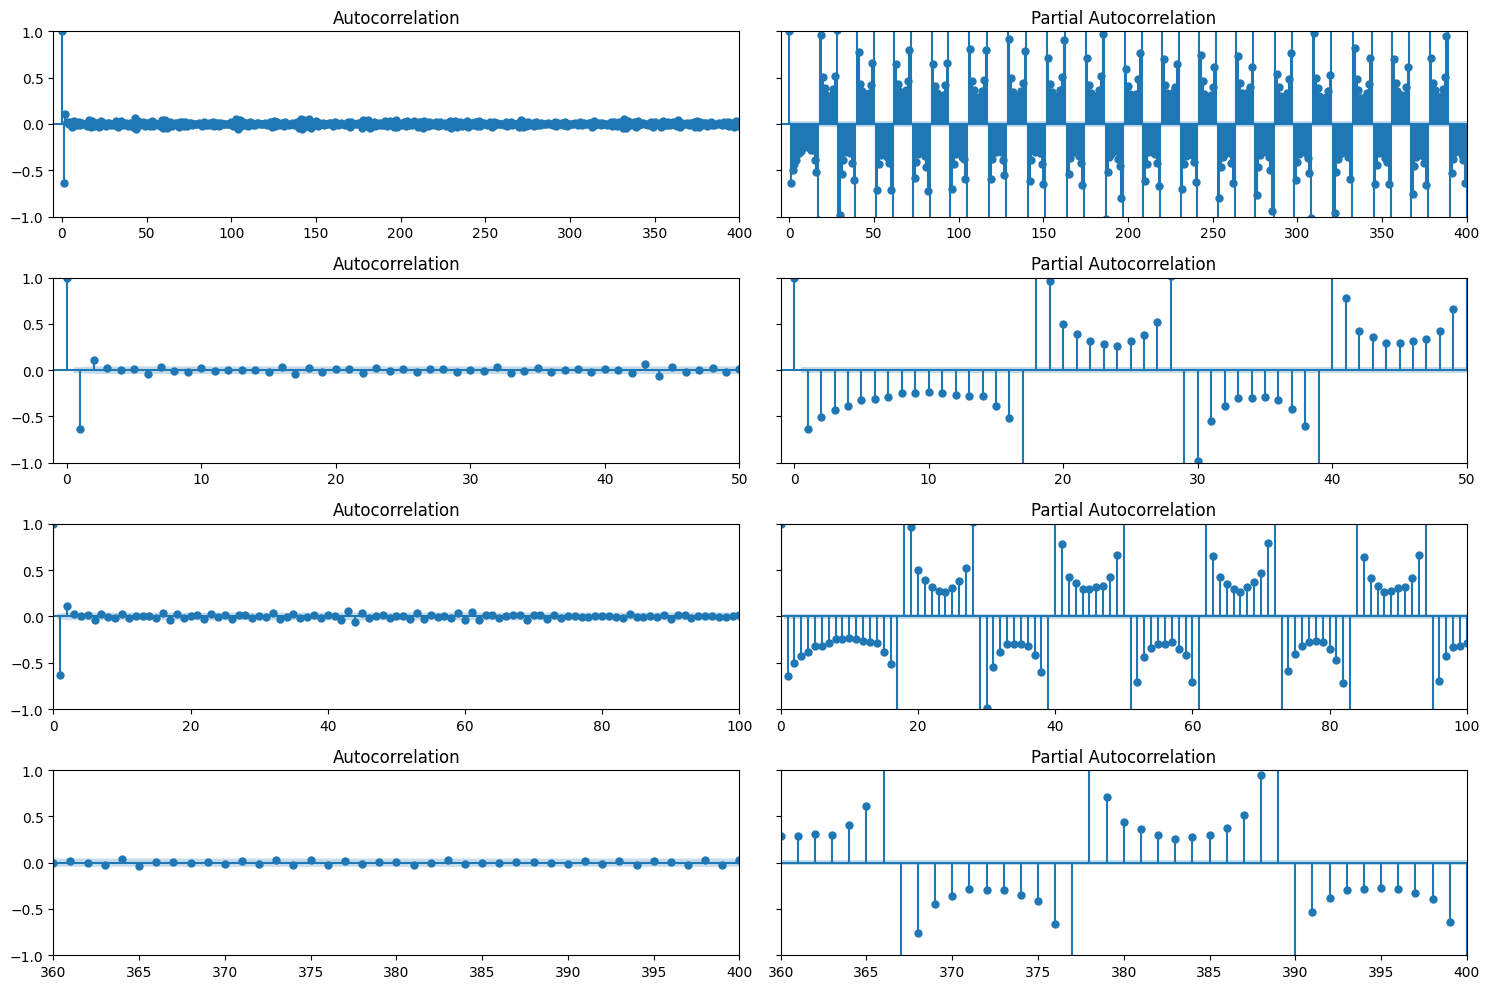

In [55]:
plot_acf_pacf(co_diff3, lags=400, xlims=[[-5, 400], [-1, 50], [0, 100], [360, 400]])

ADF test for CO diff1:

ADF Statistic: -28.728719
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


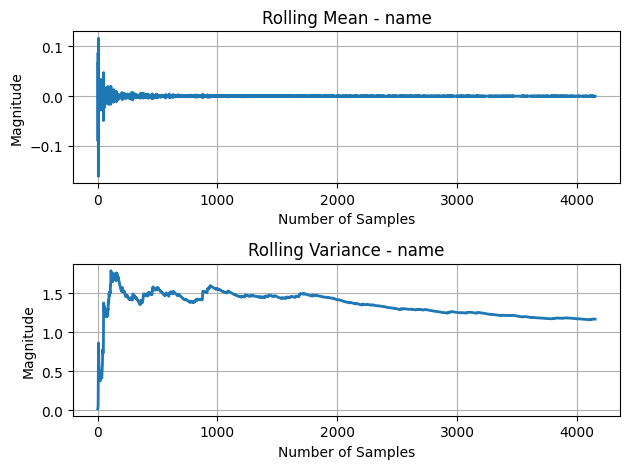

In [56]:
whiteness_test(pd.Series(co_diff3), 'CO diff1')

In [57]:
print_strength_seas_tren(co_diff3, name='Second order non-seaonally differenced')

Strength of trend in Second order non-seaonally differenced is: 0.0%
Strength of seasonality in Second order non-seaonally differenced is 34.38974209534999%


## GPAC

In [58]:
from Utilities.Correlation import Correlation as Corr
corr = Corr()

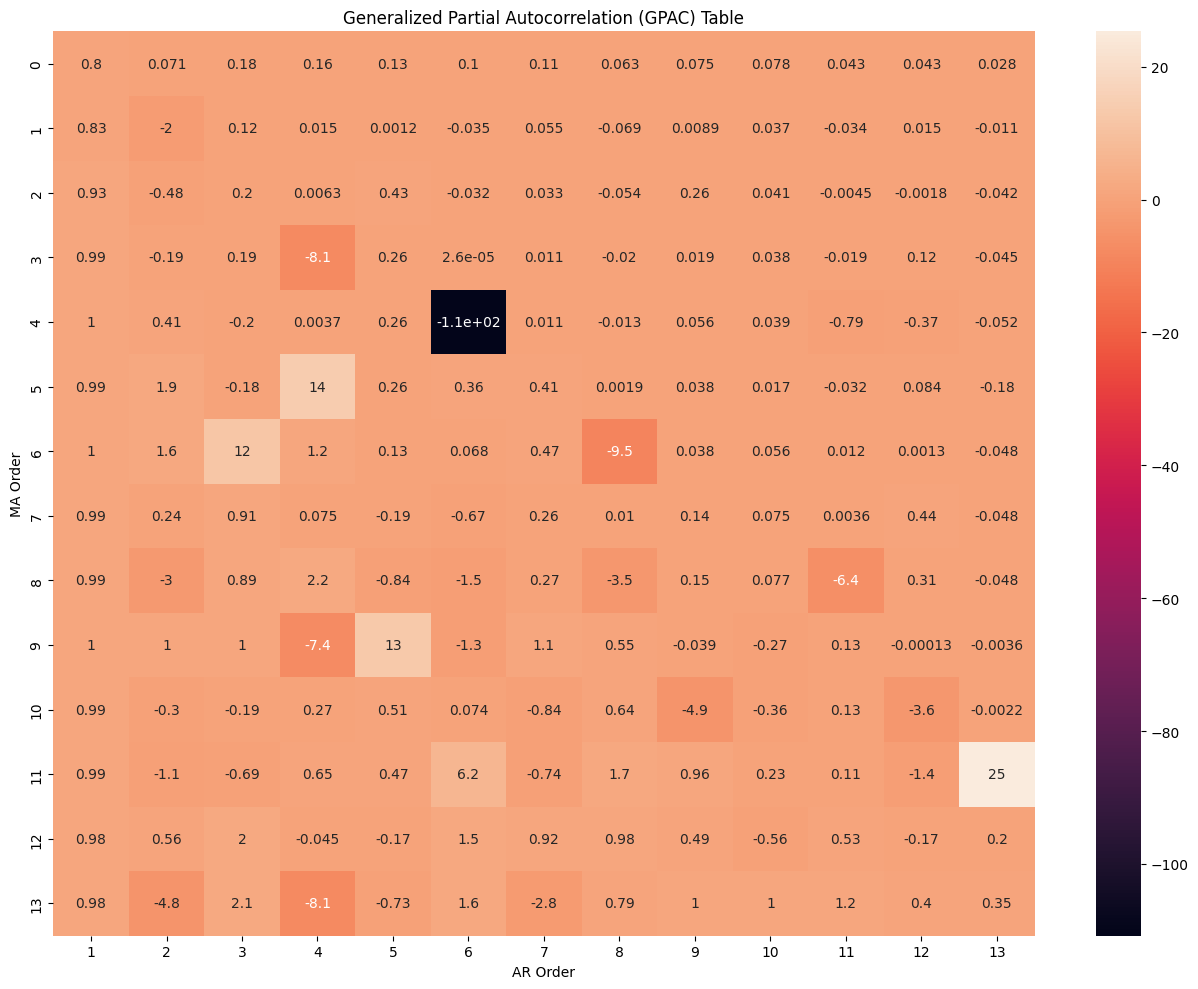

In [59]:
acf_vals, _ = corr.acf(co_log, max_lag=28, plot=False, return_acf=True)
gpac_vals = gpac_table(acf_vals, na=13, nb=13, plot=False)
plt.figure(figsize=(13, 10))
sns.heatmap(gpac_vals, annot=True)
plt.xticks(ticks=np.array(list(range(13))) + .5, labels=list(range(1, 14)))
plt.title('Generalized Partial Autocorrelation (GPAC) Table')
plt.xlabel('AR Order')
plt.ylabel('MA Order')
plt.tight_layout()
plt.show()

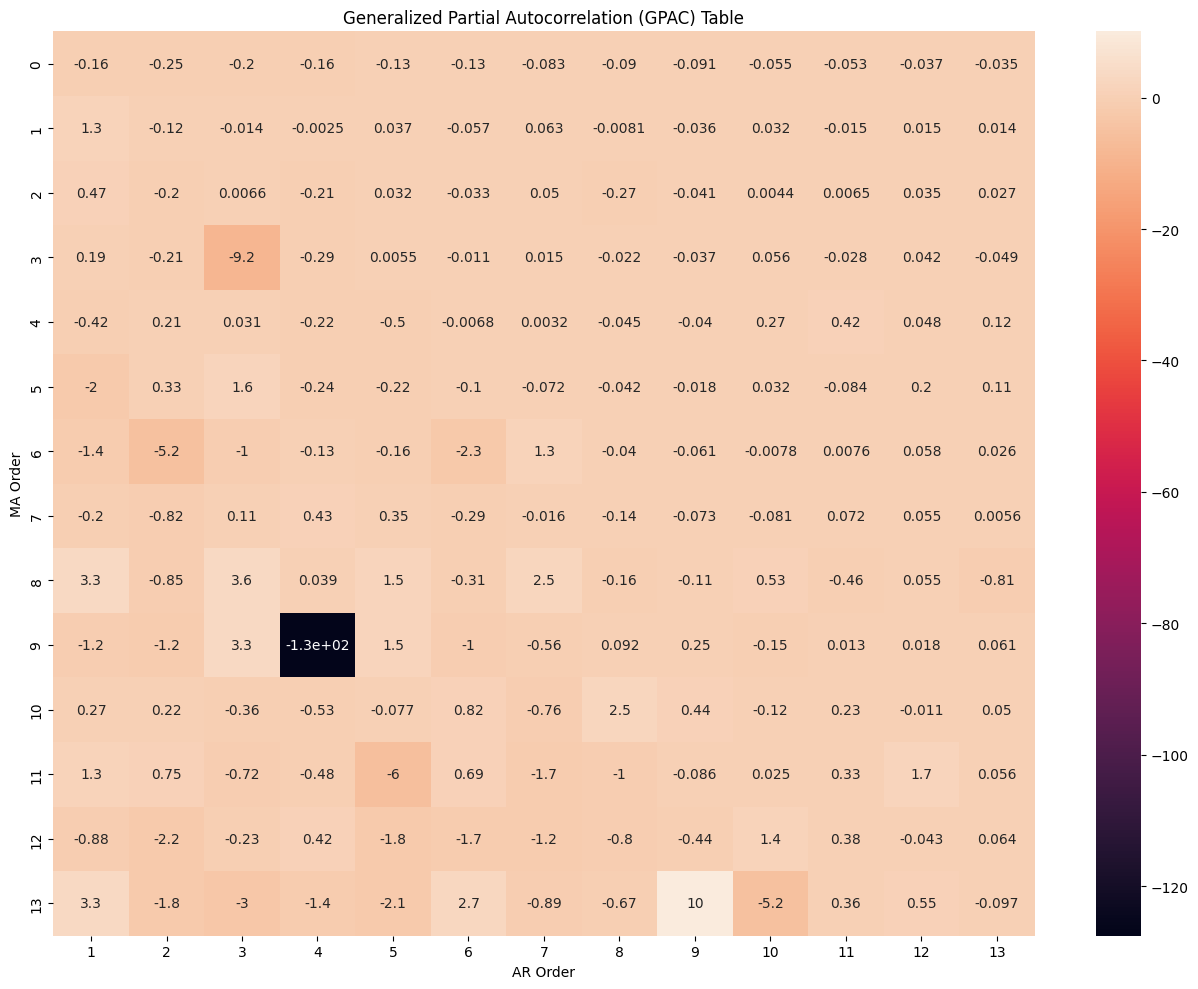

In [60]:
acf_vals, _ = corr.acf(co_diff1, max_lag=28, plot=False, return_acf=True)
gpac_vals = gpac_table(acf_vals, na=13, nb=13, plot=False)
plt.figure(figsize=(13, 10))
sns.heatmap(gpac_vals, annot=True)
plt.xticks(ticks=np.array(list(range(13))) + .5, labels=list(range(1, 14)))
plt.title('Generalized Partial Autocorrelation (GPAC) Table')
plt.xlabel('AR Order')
plt.ylabel('MA Order')
plt.tight_layout()
plt.show()

## Modeling attempt 1

In [61]:
help(sm.tsa.ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima.model:

class ARIMA(statsmodels.tsa.statespace.sarimax.SARIMAX)
 |  ARIMA(endog, exog=None, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, enforce_stationarity=True, enforce_invertibility=True, concentrate_scale=False, trend_offset=1, dates=None, freq=None, missing='none', validate_specification=True)
 |  
 |  Autoregressive Integrated Moving Average (ARIMA) model, and extensions
 |  
 |  This model is the basic interface for ARIMA-type models, including those
 |  with exogenous regressors and those with seasonal components. The most
 |  general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows
 |  all specialized cases, including
 |  
 |  - autoregressive models: AR(p)
 |  - moving average models: MA(q)
 |  - mixed autoregressive moving average models: ARMA(p, q)
 |  - integration models: ARIMA(p, d, q)
 |  - seasonal models: SARIMA(P, D, Q, s)
 |  - regression with errors that follow one of the above ARIM

In [62]:
arima_fit = sm.tsa.arima.ARIMA(endog=co_log, order=(1,0,0), trend='n').fit()

In [63]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CO AQI   No. Observations:                 4155
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2194.121
Date:                Wed, 21 Dec 2022   AIC                           4392.243
Time:                        21:14:25   BIC                           4404.907
Sample:                             0   HQIC                          4396.723
                               - 4155                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9865      0.003    358.504      0.000       0.981       0.992
sigma2         0.1682      0.003     55.301      0.000       0.162       0.174
===================================================================================
Ljung-Box (L1) (Q):                 110.69   Jarque-Bera (JB):               834.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
co_log.shape

(4155,)

In [65]:
y_hat = arima_fit.predict(start=0, end=co_log.shape[0]-1)

In [66]:
co_log.head()

0    3.218876
1    3.258097
2    3.332205
3    3.526361
4    3.737670
Name: CO AQI, dtype: float64

In [67]:
y_hat[:5]

0    0.000000
1    3.175520
2    3.214212
3    3.287322
4    3.478863
Name: predicted_mean, dtype: float64

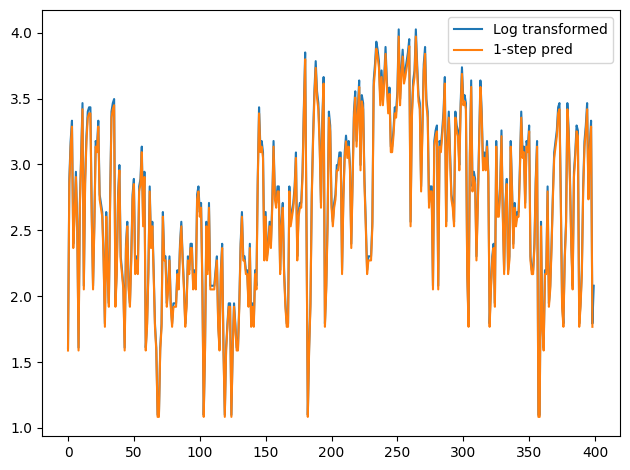

In [68]:
plt.figure()
plt.plot(co_log[100:500].reset_index(drop=True), label='Log transformed')
plt.plot(y_hat[101:500].reset_index(drop=True), label='1-step pred')
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
co_log

0       3.218876
1       3.258097
2       3.332205
3       3.526361
4       3.737670
          ...   
4150    1.609438
4151    1.609438
4152    1.098612
4153    1.098612
4154    1.098612
Name: CO AQI, Length: 4155, dtype: float64

In [70]:
y_hat

0       0.000000
1       3.175520
2       3.214212
3       3.287322
4       3.478863
          ...   
4150    1.767626
4151    1.587760
4152    1.587760
4153    1.083815
4154    1.083815
Name: predicted_mean, Length: 4155, dtype: float64

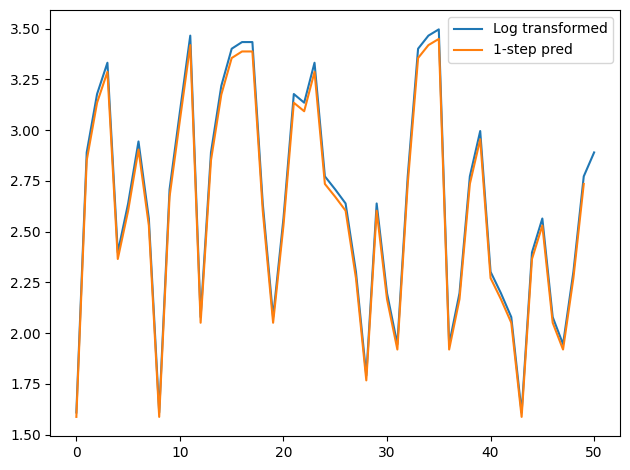

In [71]:
plt.figure()
# plt.plot(co_log.values[1:51], label='Log transformed')
# plt.plot(y_hat.values[2:52], label='1-step pred')
plt.plot(co_log.values[100:151], label='Log transformed')
plt.plot(y_hat.values[101:151], label='1-step pred')
plt.legend()
plt.tight_layout()
plt.show()

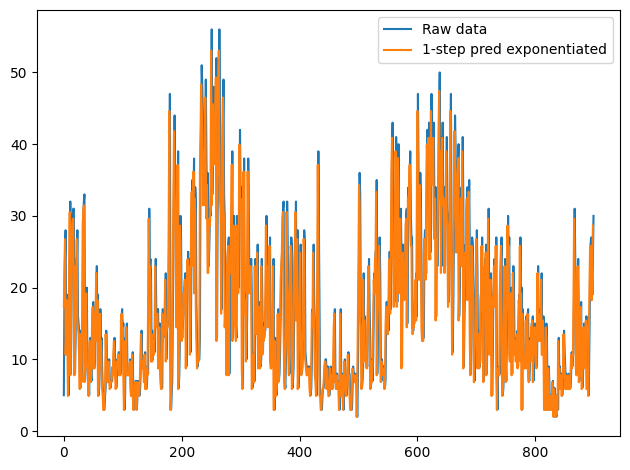

In [72]:
plt.figure()
plt.plot(co.values[100:1000], label='Raw data')
plt.plot(np.exp(y_hat.values[102:1001]), label='1-step pred exponentiated')
plt.legend()
plt.tight_layout()
plt.show()

In [73]:
len(co_log[1:].values)

4154

In [74]:
len(co_log.values[1:len(co_log.values)-1])

4153

In [75]:
len(y_hat.values[1:])

4154

In [76]:
tmp_residuals = co_log.values - y_hat.values

In [77]:
sm.stats.acorr_ljungbox(tmp_residuals, lags=[50])

,lb_stat,lb_pvalue
50,390.30166,3.019226e-54


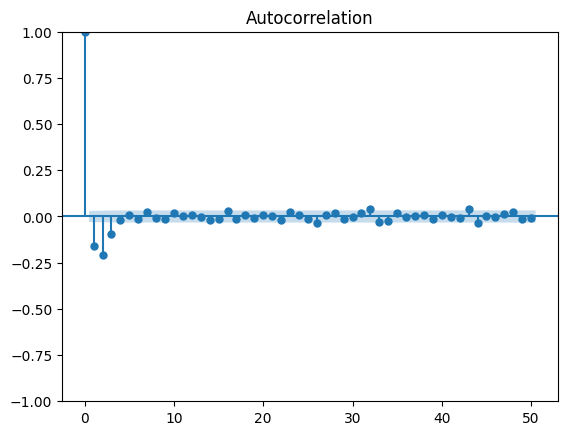

In [78]:
residuals = co_log.values - y_hat.values
plot_acf(residuals, lags=50)
plt.show()

In [79]:
sm.stats.acorr_ljungbox(residuals, lags=[50])

,lb_stat,lb_pvalue
50,390.30166,3.019226e-54


In [80]:
arima_fit2 = sm.tsa.ARIMA(endog=co_log, order=(1,0,0), trend='n').fit()

In [81]:
arima_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CO AQI   No. Observations:                 4155
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2194.121
Date:                Wed, 21 Dec 2022   AIC                           4392.243
Time:                        21:14:26   BIC                           4404.907
Sample:                             0   HQIC                          4396.723
                               - 4155                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9865      0.003    358.504      0.000       0.981       0.992
sigma2         0.1682      0.003     55.301      0.000       0.162       0.174
===================================================================================
Ljung-Box (L1) (Q):                 110.69   Jarque-Bera (JB):               834.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
y_hat2 = arima_fit2.predict()

In [83]:
co_log.head()

0    3.218876
1    3.258097
2    3.332205
3    3.526361
4    3.737670
Name: CO AQI, dtype: float64

In [84]:
y_hat2[:5]

0    0.000000
1    3.175520
2    3.214212
3    3.287322
4    3.478863
Name: predicted_mean, dtype: float64

### Assessing fit on train set

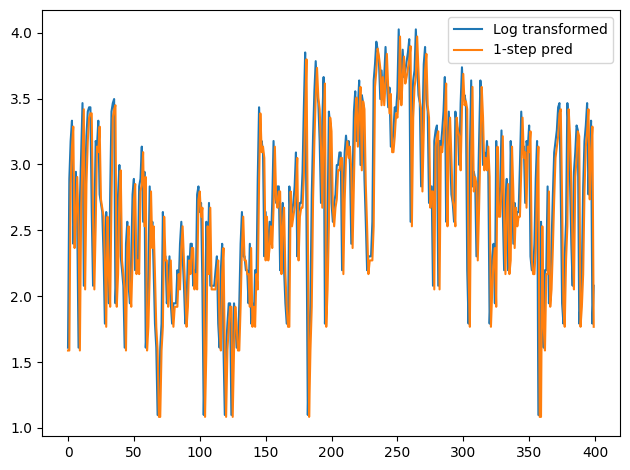

In [85]:
plt.figure()
plt.plot(co_log[100:500].reset_index(drop=True), label='Log transformed')
plt.plot(y_hat2[100:500].reset_index(drop=True), label='1-step pred')
plt.legend()
plt.tight_layout()
plt.show()

### Assessing fit on test set

In [86]:
y_forecast = arima_fit2.predict(start=train_test_split, 
                                end=train_test_split+test_len)

In [87]:
y_forecast

4155    1.083815e+00
4156    1.069216e+00
4157    1.054815e+00
4158    1.040607e+00
4159    1.026591e+00
            ...     
5933    3.660576e-11
5934    3.611270e-11
5935    3.562629e-11
5936    3.514642e-11
5937    3.467302e-11
Name: predicted_mean, Length: 1783, dtype: float64

In [88]:
co_test_log

4155    0.693147
4156    0.693147
4157    1.098612
4158    0.693147
4159    1.609438
          ...   
5932    1.098612
5933    1.098612
5934    0.693147
5935    0.693147
5936    1.098612
Name: CO AQI, Length: 1782, dtype: float64

In [89]:
y_forecast

4155    1.083815e+00
4156    1.069216e+00
4157    1.054815e+00
4158    1.040607e+00
4159    1.026591e+00
            ...     
5933    3.660576e-11
5934    3.611270e-11
5935    3.562629e-11
5936    3.514642e-11
5937    3.467302e-11
Name: predicted_mean, Length: 1783, dtype: float64

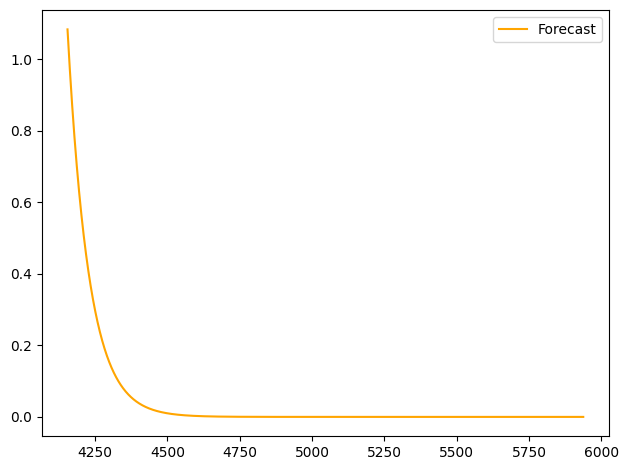

In [90]:
plt.figure()
# plt.plot(np.exp(co_test_log), label='Log transformed')
plt.plot(y_forecast, color='orange', label='Forecast')
plt.legend()
plt.tight_layout()
plt.show()

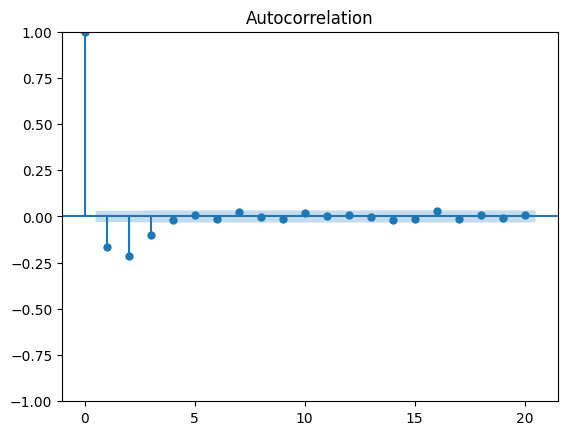

In [91]:
residuals2 = co_log[1:] - y_hat2[1:].reset_index(drop=True).values
plot_acf(residuals2, lags=20)
plt.show()

In [92]:
sm.stats.acorr_ljungbox(residuals, lags=[50])

,lb_stat,lb_pvalue
50,390.30166,3.019226e-54


## Modeling attempt 3

In [93]:
arima_fit3 = sm.tsa.ARIMA(endog=co_log, order=(4,1,3), trend='n').fit()

/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
arima_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CO AQI   No. Observations:                 4155
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1719.465
Date:                Wed, 21 Dec 2022   AIC                           3454.929
Time:                        21:14:27   BIC                           3505.584
Sample:                             0   HQIC                          3472.851
                               - 4155                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7622      0.043    -17.722      0.000      -0.846      -0.678
ar.L2         -0.3793      0.039     -9.820      0.000      -0.455      -0.304
ar.L3          0.3109      0.032      9.684      0.000       0.248       0.374
ar.L4         -0.1303      0.018     -7.182      0.000      -0.166      -0.095
ma.L1          0.3913      0.043      9.187      0.000       0.308       0.475
ma.L2         -0.2249      0.034     -6.649      0.000      -0.291      -0.159
ma.L3         -0.8447      0.037    -22.660      0.000      -0.918      -0.772
sigma2         0.1336      0.002     56.627      0.000       0.129       0.138
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               688.12
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Experimental

In [95]:
train_test_split

4155

In [96]:
co_log.shape

(4155,)

In [97]:
tmp_predict_mod3 = arima_fit3.predict()

In [98]:
len(tmp_predict_mod3)

4155

In [99]:
tmp_predict_mod3

0       0.000000
1       3.218876
2       3.251769
3       3.307881
4       3.447994
          ...   
4150    1.697973
4151    1.497086
4152    1.563998
4153    1.208370
4154    1.282896
Name: predicted_mean, Length: 4155, dtype: float64

In [115]:
tmp_residual3 = co_log.values - tmp_predict_mod3.values

In [121]:
from os.path import abspath

In [122]:
abspath('')

'/mnt/c/Users/Rajkumar/OneDrive - The George Washington University/Time Series Analysis'

In [123]:
np.save('Project/tmp_residuals3.npy', tmp_residual3)

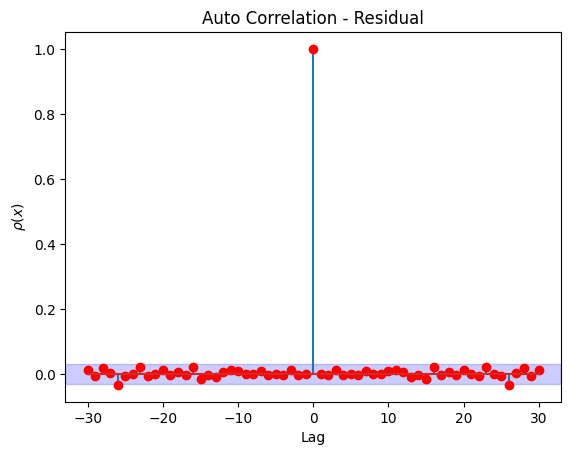

In [125]:
tmp_acf_res3, _ = corr.acf(x=tmp_residual3, max_lag=30, name='Residual', return_acf=True, 
                        plot=True)

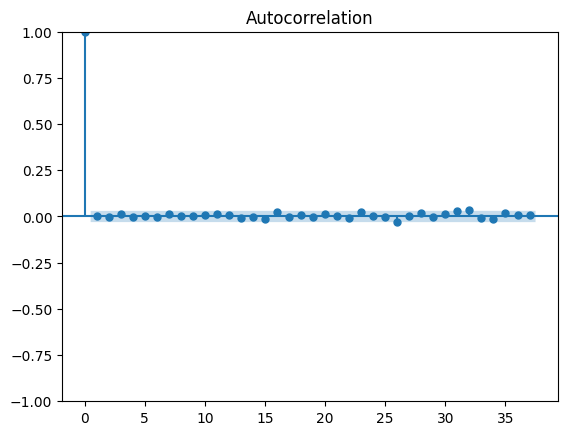

In [118]:
plot_acf(tmp_residual3)
plt.show()

In [126]:
train_test_split * (tmp_acf_res3[1:].T @ tmp_acf_res3[1:])

16.642747327996084

In [127]:
from scipy.stats import chi2

In [128]:
chi2.ppf(0.95, 30-4-3)

35.17246162690806

#### Do not fold while folding Experimental

In [105]:
y_hat3 = arima_fit3.predict()

In [106]:
co_log.head()

0    3.218876
1    3.258097
2    3.332205
3    3.526361
4    3.737670
Name: CO AQI, dtype: float64

In [107]:
y_hat3[:5]

0    0.000000
1    3.218876
2    3.251769
3    3.307881
4    3.447994
Name: predicted_mean, dtype: float64

### Assessing fit on train set

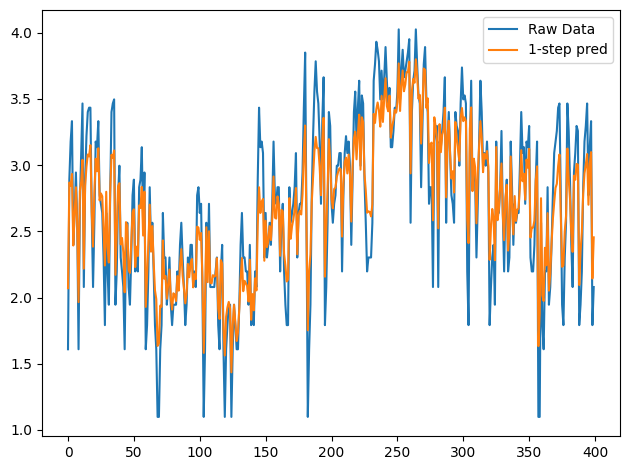

In [108]:
plt.figure()
plt.plot(co_log[100:500].reset_index(drop=True), label='Raw Data')
plt.plot(y_hat3[101:501].reset_index(drop=True), label='1-step pred')
plt.legend()
plt.tight_layout()
plt.show()

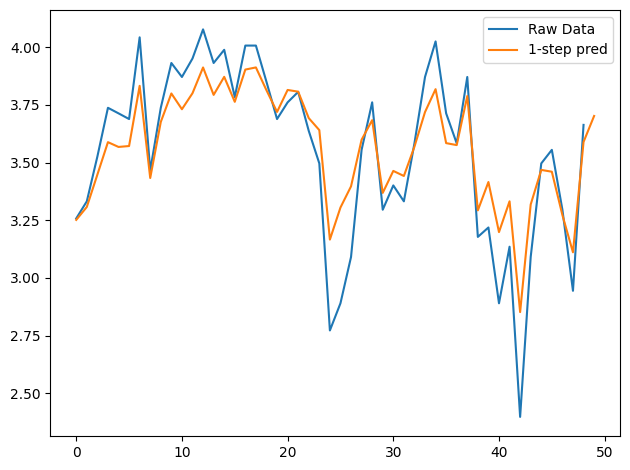

In [109]:
plt.figure()
plt.plot(co_log[1:50].reset_index(drop=True), label='Raw Data')
plt.plot(y_hat3[2:52].reset_index(drop=True), label='1-step pred')
plt.legend()
plt.tight_layout()
plt.show()

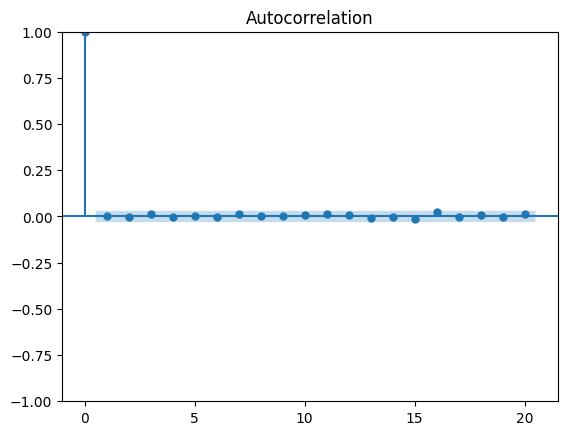

In [110]:
residuals3 = co_log.values - y_hat3.values
plot_acf(residuals3, lags=20)
plt.show()

In [111]:
sm.stats.acorr_ljungbox(residuals3, lags=[50])

,lb_stat,lb_pvalue
50,45.502576,0.654221


### Assessing fit on test set

In [112]:
sm

<module 'statsmodels.api' from '/home/rajkumarcm/venv/lib/python3.8/site-packages/statsmodels/api.py'>

In [113]:
# y_forecast3 = arima_fit3.predict(start=train_test_split, 
#                                 end=train_test_split + test_len)
y_forecast3 = arima_fit3.forecast(test_len)

/tmp/ipykernel_289/1353816926.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(co_test_log[1:].reset_index(drop=True), label='Raw Data')
/tmp/ipykernel_289/1353816926.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(y_forecast3[1:].reset_index(drop=True), label='Forecast')


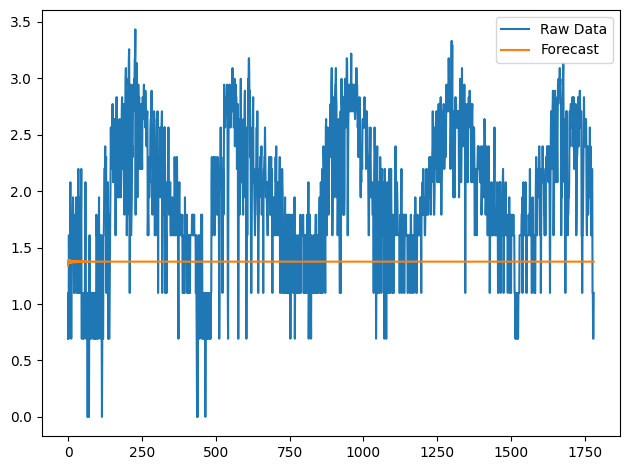

In [114]:
plt.figure()
plt.plot(co_test_log[1:].reset_index(drop=True), label='Raw Data')
plt.plot(y_forecast3[1:].reset_index(drop=True), label='Forecast')
plt.legend()
plt.tight_layout()
plt.show()